# Visualizing Models, Data, and Training with TensorBoard


In this notebook, we will see how to load in data, feed it through a model we defined as a subclass of nn.Module. We train this model training data, and test it on test data. We will print out some statistics as the model is training to see whether the model is training. We will also show how to visualize the results of a neural network training runs using TensorBoard.

**Importing libraries**

In [57]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import torch # Like a numpy but we could work with GPU by pytorch library
import torch.nn as nn # Neural Network Implemented with pytorch
import torchvision # A library for work with pretrained model and datasets
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import glob
import os
%matplotlib inline



In [58]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

image_size = (224, 224)#resizing image size

image_row_size = image_size[0] * image_size[1]


**Creating dataset class**

In [59]:
#Creating class for loading the dataset
class CatDogDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        return im.view(-1), classCategory

**Transforms**

In [60]:
 
transform = transforms.Compose([
                                transforms.Resize(image_size), 
                                transforms.ToTensor(), 
                                ])

**Dataset function**

In [61]:
#Here we are calling the dataset fuction that we created above
path    = 'train'
dataset = CatDogDataset(path, transform=transform)
path_test    = 'test'
data_train = CatDogDataset(path, transform=transform)
data_test=CatDogDataset(path_test, transform=transform)

**Dataloader function**

In [62]:

shuffle     = True
batch_size  = 80
num_workers = 0
train_loader  = DataLoader(dataset=data_train, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers)


test_loader  = DataLoader(dataset=data_test, 
                         shuffle=False, 
                         batch_size=batch_size, 
                         num_workers=num_workers)



In [63]:
#checking for number of classes
train_loader.dataset.classes

['cat', 'dog']

In [64]:
#constants for classes
classes = ('cat','dog')

In [65]:

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

**Create the model class**

In [66]:
n_features = 8 # number of feature maps
input_size= 224*224*3
output_size = 2
#Simple convolutional neural network with two layers
#nn.Module contains layers
class CNN(nn.Module):
    def __init__(self, input_size, n_features, output_size):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_features, kernel_size=5)
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)
        self.fc1 = nn.Linear(n_features*53*53, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, n_features*53*53)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
   
    

net = CNN(input_size, n_features, output_size)

**Optimizer and criterion function**

In [67]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Setting up TensorBoad**

Here, we set up TensorBoard, import tensorbod from torch.utils and define sommuary write which helps in writing information to TensorBoard

In [68]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
#summary writer writes summary of what you are doing
writer = SummaryWriter('runs/cat_dog_experiment_1')

**Writing to TensorBoard**

We now write images to the TensorBoard.

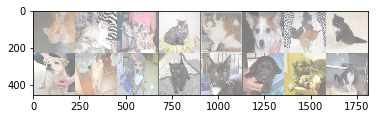

In [80]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images=images.view(-1, 3, 224, 224)

# create grid of images
img_grid = torchvision.utils.make_grid(images[:16])



# show images
matplotlib_imshow(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('four_cats_dogs_images', img_grid)

This should be run in the terminal without the ! or here on the notebook with !. This will create a folder called runs in your directory. The next step is to open a new google page and run the link in the terminal.

In [ ]:

#!tensorboard --logdir=runs

**We inspect the model using TensorBoard by visualizing it**

In [70]:
writer.add_graph(net, images)
writer.close()

At this point, we can go ahead to the TensorBoard and double click on 'Net' to see it expand and see a detailed view of the individual operations that make up the model

In [82]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
#images, labels = select_n_random(dataset.data, dataset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 3 * 224 * 224)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

**Tracking model training with TensorBoard**

We now log the running loss to TensorBoard, along with a view into the predictions the model is making via the plot_classes_preds function.



In [72]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

**Training and testing the model**


In [73]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs =inputs.view(-1,3,224,224)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 0 and i>5:    # every 10 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(train_loader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(train_loader) + i)
            running_loss = 0.0
print('Finished Training')


Finished Training


We can now look at the  scalars tab to see the running loss plotted.

**Assessing trained models with TensorBoard**

In [74]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images=images.view(-1, 3, 224, 224)
        
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

We can now see a 'PR Curves' tab that contains the precision-recall curves for each class.